# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import numpy as np
import random

# seed our random generator, we want our testing to be consistent between runs
random.seed(123)

# Load datasets
training_file = '../data/traffic-signs-train.p'
testing_file = '../data/traffic-signs-test.p'
sign_names_file = './signnames.csv'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

sign_names = np.array([])
data_row = False # to help skip over header
import csv
with open(sign_names_file) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            if data_row:
                sign_names = np.append(sign_names, row[1])
            else:
                data_row = True


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Lable data shape = ", y_train[0:])
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Lable data shape =  [ 0  0  0 ..., 42 42 42]
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [3]:
import matplotlib.pyplot as plt

# Visualizations will be shown in the notebook.
%matplotlib inline

def select_samples(count, images, labels):
    # select count random images and labels
    # count: number of samples to select
    # images: large image set to sub sample from
    # labels: large label set for the images
    #
    # returns (sample_images, sample_labels)
    indices = np.array(random.sample(range(images.shape[0]), count))
    return (images[indices], labels[indices])

def plot_samples(images, label_names, title, label_indices=None, cmap='jet'):
    # plot the sample images with associated labels
    # images: the images to plot
    # label_indices: label index for each image plot
    # label_name: string representation of the label for each image
    # title: single title for the group of images
    
    if label_indices is None:
        label_indices = [i for i in range(len(label_names))]
    ncols = images.shape[0]
    nrows = ncols / 2 + 1
    fig = plt.figure()
    fig.suptitle(title, fontsize=14, y=1.1)
    fig.subplots_adjust(hspace=.5)
    
    for i in range(ncols):
        subplot = plt.subplot(nrows, ncols / 2, i+1)
        subplot.axis('off')
        subplot.set_title(label_names[label_indices[i]])
        image = images[i]
        if image.shape[2] == 1:
            image = image[:,:,0] * 3
        plt.imshow(image, cmap=cmap)


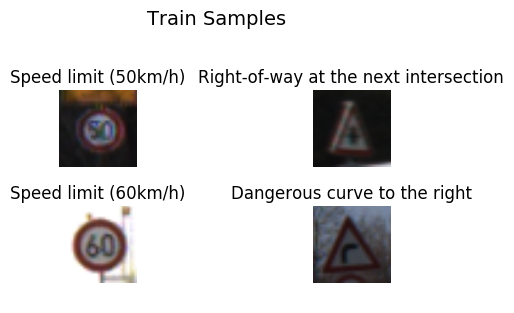

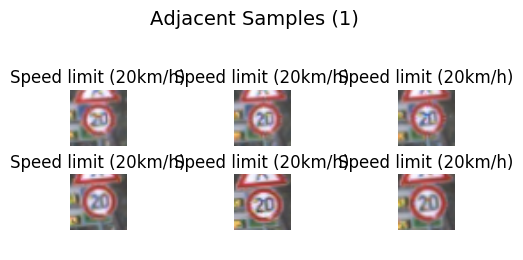

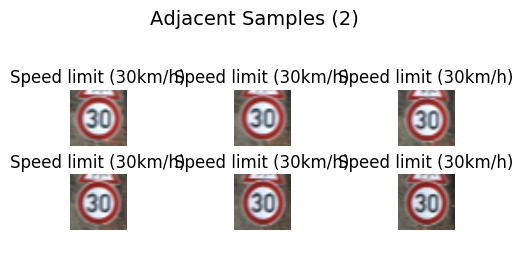

In [4]:
# number of sample images to display for each dataset
n_samples = 4

# select an plot samples from training set
train_sample_images, train_sample_labels = select_samples(n_samples, X_train, y_train)
plot_samples(train_sample_images, sign_names, 'Train Samples', label_indices=train_sample_labels)
plt.show()

# show adjacent images are for the same sign stream
train_sample_images, train_sample_labels = (X_train[0:6], y_train[0:6])
plot_samples(train_sample_images, sign_names, 'Adjacent Samples (1)', label_indices=train_sample_labels)
plt.show()
train_sample_images, train_sample_labels = (X_train[1000:1006], y_train[1000:1006])
plot_samples(train_sample_images, sign_names, 'Adjacent Samples (2)', label_indices=train_sample_labels)
plt.show()


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

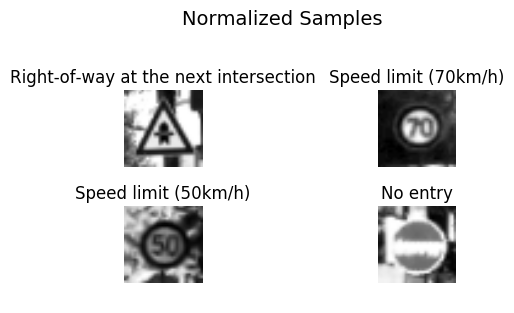

In [5]:
### Preprocess the data here.

import cv2

# function to help normalize
def normalize(values, new_min=-128, new_max=128):
    old_max = np.max(values)
    old_min = np.min(values)
    return ((new_max - new_min) * (values - old_min)) / (old_max - old_min) + new_min

# the standard preprocessing to be done to all images
# convert color images to grayscale
# normalize the image colors centered around zero
def apply_preprocess(image):
    return normalize(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

# apply the preprocessing routine to each image
X_gray = np.empty([X_train.shape[0], X_train.shape[1], X_train.shape[2], 1], dtype=int)
for i in range(X_train.shape[0]):
    X_gray[i][:,:,0] = apply_preprocess(X_train[i])

X_train = X_gray

# redisplay as grayscale samples after conversion
norm_images, norm_labels = select_samples(n_samples, X_train, y_train)
plot_samples(norm_images, sign_names, 'Normalized Samples', label_indices=norm_labels, cmap='gray')
plt.show()


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** For preprocessing we converted the data to grayscale. Removing color was suggested by the linked research paper (http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). As removing color improved the results, color must be a distracting parameter to the classifier. We assume shapes and lines are more important for matching traffic signs in the network.

Original training set size: 39209
largest class size 2220 for id 2 [Speed limit (50km/h)]


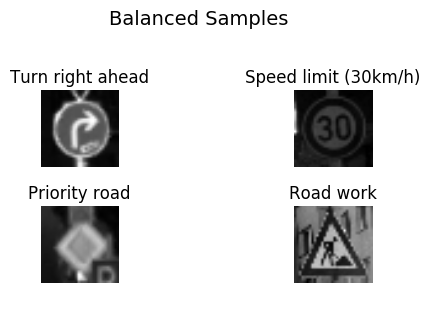

Using 1.3333333333333335 percent of training as validation
New training set size: 95460
Validation size 1290
Sampes of each class: 43


In [6]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
from random import randint

print("Original training set size: {}".format(X_train.shape[0]))

def per_feature_split(X_train, y_train, test_size=0.15, random_state=0):
    valid_indices = np.array([], dtype='int64')
    count = 0
    samples = np.empty([n_classes, X_train.shape[1], X_train.shape[2], X_train.shape[3]], dtype=int)
    for sign_id in range(n_classes):
        init_count = valid_indices.shape[0]
        # select all indices for a specific sign_id
        all_indices_for_sign = np.where(y_train == sign_id)[0]
        # we originally tried to extract the first 15% of the indices like the following line
        # int(test_size * all_indices_for_sign.shape[0])
        # but then some items were over represented in the validation set
        # and were giving us suspiciously high or low accuracy estimates
        # we extract a continuous block, rather than randomly because similar images are adjacent
        valid_indices = np.append(valid_indices, all_indices_for_sign[0:30])                            
        end_count = valid_indices.shape[0]
        # we pick index 30 from the class category, this choice is somewhat arbitrary,
        # but index 0 tends to be the first/furthest away in a video series and is more blurry
        samples[sign_id][:,:] = X_train[all_indices_for_sign[30]]

    X_valid = X_train[valid_indices]                              
    y_valid = y_train[valid_indices]
    X_train = np.delete(X_train, valid_indices, axis=0)
    y_train = np.delete(y_train, valid_indices, axis=0)
    
    return (X_train, X_valid, y_train, y_valid, samples)

# separate a validation set out of the training set
X_train, X_valid, y_train, y_valid, sign_samples = per_feature_split(X_train, y_train)

def jitter(image):
    # random rotation
    #     rows = image.shape[0]
    #     cols = image.shape[1]
    #     M = cv2.getRotationMatrix2D((16,16), random.uniform(-10., 10.), 1)
    #     image = cv2.warpAffine(image, M, (32, 32))
    # random obstruction (we draw an elipse)
    # http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_drawing_functions/py_drawing_functions.html
    #     center = (randint(0, image.shape[0]), randint(0, image.shape[1]))
    #     axes = (randint(1, image.shape[0]/4), randint(1, image.shape[1]/4))
    #     angle = randint(0, 360)
    #     (arcStart, arcEnd) = (0, randint(360))
    #     cv2.ellipse(image, center, axes, angle, arcStart, arcEnd, randint(-128, 128), -1)
    
    return image

def balance_data(images, labels, classes):
    # certain classes are overrepresented in the training set
    # we'll augment all the classes so they all have the same number of samples
    from collections import Counter
    counter = Counter(labels)

    largest_class_id, largest_class_size = counter.most_common(2)[0]
    print("largest class size {} for id {} [{}]".format(largest_class_size, largest_class_id, classes[largest_class_id]))

    augmented_size = largest_class_size * len(classes)
    X_augment = np.empty([augmented_size, images.shape[1], images.shape[2], images.shape[3]], dtype=int)
    y_augment = np.empty([augmented_size], dtype=int)

    for i in range(images.shape[0]):
        X_augment[i][:,:] = images[i]
        y_augment[i] = labels[i]

    idx = images.shape[0]
    for [class_id, class_size] in counter.most_common():
        diff_size = largest_class_size - class_size
        all_indices_for_sign = np.where(labels == class_id)[0]
        for _ in range(diff_size):
            random_copy_idx = all_indices_for_sign[randint(0, class_size-1)]
            X_augment[idx] = jitter(images[random_copy_idx])
            y_augment[idx] = labels[random_copy_idx]
            idx += 1
    
    return (X_augment, y_augment)

X_train, y_train = balance_data(X_train, y_train, sign_names)

check_images, check_labels = select_samples(n_samples, X_train, y_train)
plot_samples(check_images, sign_names, 'Balanced Samples', label_indices=check_labels, cmap='gray')
plt.show()

print("Using {} percent of training as validation".format(
    X_valid.shape[0] / (X_train.shape[0] + X_valid.shape[0]) * 100.))
print("New training set size: {}".format(X_train.shape[0]))
print("Validation size {}".format(X_valid.shape[0]))
print("Sampes of each class: {}".format(sign_samples.shape[0]))



In [7]:
from sklearn.utils import shuffle

# randomize the samples order so we don't gain too much confidence due to similar adjacent images
X_train, y_train = shuffle(X_train, y_train)

# question: does order of the validation set matter?
# it shouldn't, but we shuffle the validation set too, just in case
X_valid, y_valid = shuffle(X_valid, y_valid)

# there's no reason to shuffle the test data, it's already randomized and order should not matter anyway
# X_test, y_test = select_samples(X_test.shape[0], X_test, y_test)

print("Training size: {}".format(X_train.shape[0]))
print("Validation size: {}".format(X_valid.shape[0]))
print("Single sample shape: {}".format(X_train[0].shape))

Training size: 95460
Validation size: 1290
Single sample shape: (32, 32, 1)


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** After reading the research paper, we confirmed the traffic signs are stored in a particular order in the pickle file. Instead of taking a random sample across the entire dataset, we take a sequence of 15% out of each of class of data. Taking adjacent images helps make it less likely that variations of the exact same sign will be in both the training data and the validation set.

However, as expected, this approach lowers our training accuracy scores. We are optimistic at this point that despite lower training scores, our approach should still perform better on unseen data.

In [8]:
import tensorflow as tf

def create_model(mu=0, sigma=0.01):
    def new_model():
        return {
            'layer1_W': tf.Variable(tf.truncated_normal((5, 5, 1, 6), mean = mu, stddev = sigma), name='layer1_W'),
            'layer1_b': tf.Variable(tf.zeros(6), name='layer1_b'),
            'layer2_W': tf.Variable(tf.truncated_normal((5, 5, 6, 16), mean = mu, stddev = sigma), name='layer2_W'),
            'layer2_b': tf.Variable(tf.zeros(16), name='layer2_b'),
            'layer3_W': tf.Variable(tf.truncated_normal([400, 120], mean = mu, stddev = sigma), name='layer3_W'),
            'layer3_b': tf.Variable(tf.zeros(120), name='layer3_b'),
            'layer4_W': tf.Variable(tf.truncated_normal([120, 84], mean = mu, stddev = sigma), name='layer4_W'),
            'layer4_b': tf.Variable(tf.zeros(84), name='layer4_b'),
            'layer5_W': tf.Variable(tf.truncated_normal([84, 43], mean = mu, stddev = sigma), name='layer5_W'),
            'layer5_b': tf.Variable(tf.zeros(43), name='layer5_b')
        }
    return new_model()

model = create_model()

EPOCHS = 100
BATCH_SIZE = 256

from tensorflow.contrib.layers import flatten

# LeNet architecture:
# INPUT -> CONV -> ACT -> POOL -> CONV -> ACT -> POOL -> FLATTEN -> FC -> ACT -> FC
def LeNet(x, model):
    
    layer1_W = model['layer1_W']
    layer1_b = model['layer1_b']
    layer2_W = model['layer2_W']
    layer2_b = model['layer2_b']
    layer3_W = model['layer3_W']
    layer3_b = model['layer3_b']
    layer4_W = model['layer4_W']
    layer4_b = model['layer4_b']
    layer5_W = model['layer5_W']
    layer5_b = model['layer5_b']
    
    # we'll use these common pooling parameters for all our pooling
    pool_filter_size = [1, 2, 2, 1]
    pool_stride_size = [1, 2, 2, 1]
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    layer1_strides = [1, 1, 1, 1]
    layer1 = tf.nn.conv2d(x, layer1_W, layer1_strides, 'VALID') + layer1_b

    # Activation.
    act1 = tf.nn.relu(layer1)
    act1 = tf.nn.dropout(act1, act1_keep_prob)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    pool1 = tf.nn.max_pool(act1, pool_filter_size, pool_stride_size, 'SAME')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    layer2_strides = [1, 1, 1, 1]
    layer2 = tf.nn.conv2d(pool1, layer2_W, layer2_strides, 'VALID') + layer2_b

    # Activation.
    act2 = tf.nn.relu(layer2)
    act2 = tf.nn.dropout(act2, act2_keep_prob)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    pool2 = tf.nn.max_pool(act2, pool_filter_size, pool_stride_size, 'SAME')

    # Flatten. Input = 5x5x16. Output = 400.
    flat2 = tf.contrib.layers.flatten(pool2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    layer3_fc = tf.reshape(flat2, [-1, layer3_W.get_shape().as_list()[0]])
    layer3_fc = tf.add(tf.matmul(layer3_fc, layer3_W), layer3_b)

    # Activation.
    act3 = tf.nn.relu(layer3_fc)
    act3 = tf.nn.dropout(act3, act3_keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    layer4_fc = tf.reshape(act3, [-1, layer4_W.get_shape().as_list()[0]])
    layer4_fc = tf.add(tf.matmul(layer4_fc, layer4_W), layer4_b)
    
    # Activation.
    act4 = tf.nn.relu(layer4_fc)
    act4 = tf.nn.dropout(act4, act4_keep_prob)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    layer5_fc = tf.reshape(act4, [-1, layer5_W.get_shape().as_list()[0]])
    layer5_fc = tf.add(tf.matmul(layer5_fc, layer5_W), layer5_b)
    
    logits = layer5_fc
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** We used the LeNet architecure from a previous lesson. We modified the Activation layers slightly to use DropOut at each layer, and we increased the number of EPOCHS so that the network would have enough tries to still learn from the dropped neurons.

In [9]:
### Train your model here.
### Feel free to use as many code cells as needed.
x = tf.placeholder(tf.float32, (None, X_train.shape[1], X_train.shape[2], X_train.shape[3]), name='x')
y = tf.placeholder(tf.int32, (None), name='y')
one_hot_y = tf.one_hot(y, 43)

act1_keep_prob = tf.placeholder(tf.float32, name='act1_keep_prob')
act2_keep_prob = tf.placeholder(tf.float32, name='act2_keep_prob')
act3_keep_prob = tf.placeholder(tf.float32, name='act3_keep_prob')
act4_keep_prob = tf.placeholder(tf.float32, name='act4_keep_prob')

rate = 0.001

logits = LeNet(x, model)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [10]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,
                                                               act1_keep_prob: 1.0,
                                                               act2_keep_prob: 1.0,
                                                               act3_keep_prob: 1.0,
                                                               act4_keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [11]:
from time import time

save_prefix = 'lenet-traffic-signs'
last_saved_file = None
saver = tf.train.Saver(model)
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    all_epoch_start_time = time()
    for i in range(EPOCHS):
        t0 = time()
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, 
                                                        act1_keep_prob: 0.9,
                                                        act2_keep_prob: 0.7,
                                                        act3_keep_prob: 0.6,
                                                        act4_keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Duration: {}s".format(round(time() - t0, 3)))
        print()
        
    total_time = round(time() - all_epoch_start_time, 3) 
    print("Average Epoch Duration: {}s".format(total_time / EPOCHS))
    print("Time for {} Epochs: {}s".format(EPOCHS, total_time))
    
    last_saved_file = '{}-{}.ckpt'.format(save_prefix, validation_accuracy)
    saver.save(sess, last_saved_file)
    print("Model saved as: {}".format(last_saved_file))

Training...

EPOCH 1 ...
Validation Accuracy = 0.740
Duration: 2.744s

EPOCH 2 ...
Validation Accuracy = 0.790
Duration: 2.301s

EPOCH 3 ...
Validation Accuracy = 0.842
Duration: 2.368s

EPOCH 4 ...
Validation Accuracy = 0.878
Duration: 2.255s

EPOCH 5 ...
Validation Accuracy = 0.862
Duration: 2.409s

EPOCH 6 ...
Validation Accuracy = 0.876
Duration: 2.326s

EPOCH 7 ...
Validation Accuracy = 0.897
Duration: 2.416s

EPOCH 8 ...
Validation Accuracy = 0.916
Duration: 2.306s

EPOCH 9 ...
Validation Accuracy = 0.901
Duration: 2.368s

EPOCH 10 ...
Validation Accuracy = 0.919
Duration: 2.292s

EPOCH 11 ...
Validation Accuracy = 0.911
Duration: 2.444s

EPOCH 12 ...
Validation Accuracy = 0.919
Duration: 2.318s

EPOCH 13 ...
Validation Accuracy = 0.933
Duration: 2.365s

EPOCH 14 ...
Validation Accuracy = 0.931
Duration: 2.325s

EPOCH 15 ...
Validation Accuracy = 0.925
Duration: 2.388s

EPOCH 16 ...
Validation Accuracy = 0.928
Duration: 2.348s

EPOCH 17 ...
Validation Accuracy = 0.915
Duration: 2

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
Optimizer: AdamOptimizer instead of basic GradientDecent. More about the difference was available on stackoverflow, but we summarize that for ourselves as Adam Optimizer being generally simpler to use, saving the developer time in tuning, with the tradeoff being AdamOptimizer uses more memory and compute time. (http://stats.stackexchange.com/questions/184448/difference-between-gradientdescentoptimizer-and-adamoptimizer-tensorflow).

Batch Size: We somewhat arbitrarily tested with 64, 128, 256 as our batch sizes. 

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._


**Answer:**

The main strategy we used for solving the problem was the LeNet architecture. We assumed it would work well enough for matching Traffic Sign shapes because it did well at matching character shapes in the MNIST data. After that, we read a variety of research papers online to get ideas for data preparation. Our python skills are apparently lacking, so some of the data prepration ideas failed to get implemented correctly which lead us to explore simpler alternatives.

The purpose of data augmentation in this case was to help avoid overfitting to the training set. We recalled the use of DropOut from previous lessions, and decided that would be an effective alternative. Ideally we would have combined data augmentation and DropOut to get better results.

We performed a significant amount of trial and error with most of the tuning parameters like learning rate, batch size, EPOCHS and various data preparation strategies. If an idea failed to achieve 80%-85% accuracy by the tenth EPOCH, we assumed it it would finish with poor results and would cancel the job to try another idea.

We did not do a rigorous job of note taking on results for each of the experiments. I generally recall Grayscale providing the best improvement. Both DropOut and our modified splitting strategy cause worse performance on the validation set.


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

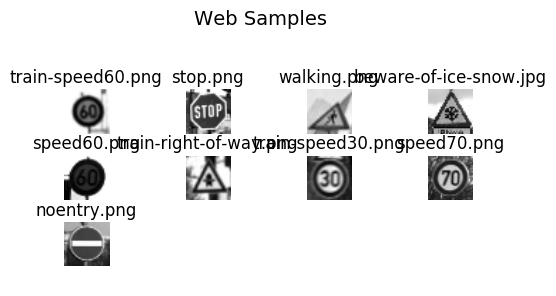

In [12]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
import numpy as np
import matplotlib.image as mpimg
import cv2

web_signs_path = './web_signs'

web_file_names = os.listdir(web_signs_path)

web_images = np.empty([len(web_file_names), 32, 32, 1])
for idx, file_name in enumerate(web_file_names):
    img = cv2.imread('/'.join([web_signs_path, file_name]))
    img = cv2.resize(img, (32, 32))
    web_images[idx][:,:,0] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plot_samples(web_images, web_file_names, 'Web Samples', cmap='gray')

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
We searched the web for a few candidate images of german signs and cropped them to focus on the sign itself rather than the surrounding area, similar to how the training data looked. We also grabbed three arbitrary images directly from the training set to see whether the classifier would recognize them again after training.

The pedestrian sign is easily confused with the right of way sign, both are a black blob in the midle of a bordered triangle.

In [13]:
import tensorflow as tf
import os

tf.reset_default_graph()

act1_keep_prob = tf.placeholder(tf.float32, name='act1_keep_prob')
act2_keep_prob = tf.placeholder(tf.float32, name='act2_keep_prob')
act3_keep_prob = tf.placeholder(tf.float32, name='act3_keep_prob')
act4_keep_prob = tf.placeholder(tf.float32, name='act4_keep_prob')

### Run the predictions here.
def predict(X_data, save_file):  
    x = tf.placeholder(tf.float32, (None, 32, 32, 1), name='x')
    model = create_model()
    logits = LeNet(x, model)
    softmax = tf.nn.softmax(logits)
    result = None
    with tf.Session() as sess:
        saver = tf.train.Saver()
        saver.restore(sess, save_file)
        print('X_data shape: {}'.format(X_data.shape))
        result = sess.run(softmax, feed_dict={x: X_data, act1_keep_prob: 1.0, act2_keep_prob: 1.0, act3_keep_prob: 1.0, act4_keep_prob: 1.0})
    return result

#uncomment below and change file name to use pre-existing file from previous run 
#last_saved_file = 'lenet-traffic-signs-0.9178294573643411.ckpt'

softmax_probs = predict(web_images, '{}/{}'.format(os.getcwd(), last_saved_file))

predicted_label_index = np.argmax(softmax_probs, axis=1)
for idx, name in zip(predicted_label_index, sign_names[predicted_label_index]):
    print('{}: {}'.format(idx, name))


X_data shape: (9, 32, 32, 1)
3: Speed limit (60km/h)
14: Stop
11: Right-of-way at the next intersection
11: Right-of-way at the next intersection
3: Speed limit (60km/h)
11: Right-of-way at the next intersection
1: Speed limit (30km/h)
4: Speed limit (70km/h)
17: No entry


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
The model predicted 7/9 correctly, or 77.7% which is worse than the expected 93% observed on the training set. Even that rate is a bit optimistic considering 3 of our 8 images were duplicated from the training set.

The visualization displays the image evaluted on the left, and a probability chart along the right. In the probability chart, the x-axis is labeled 0-42 for each of the sign ids. Black color indicates near zero probability, while white indicates closer to 1.0 probability. 

The two incorrectly predicted "Right of way" signs both have a yellowish color, indicating less likely than the white we see in other charts. In the pedestrian sign chart we can see a dark maroon color at index 30, indicating this was the next distant runner up. The other signs do not have easy to see second place choices.

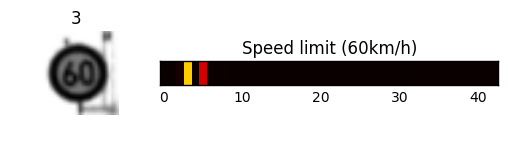

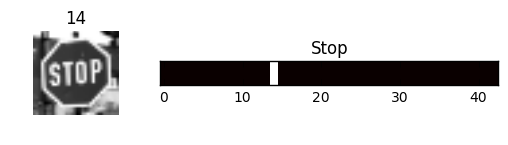

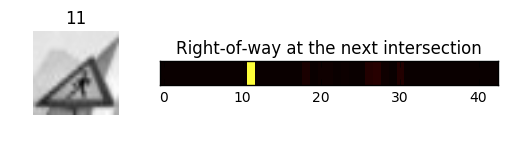

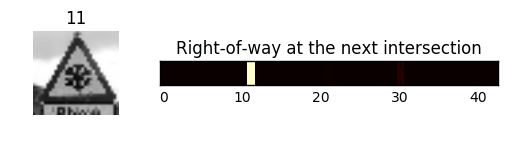

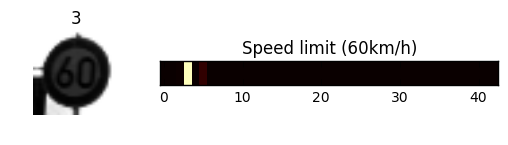

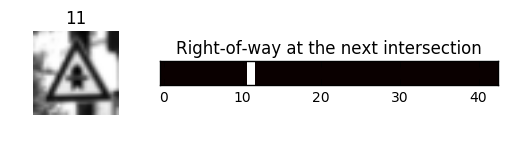

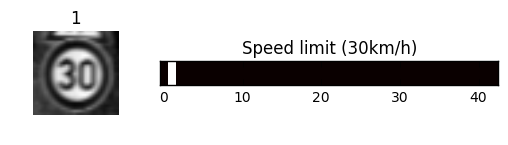

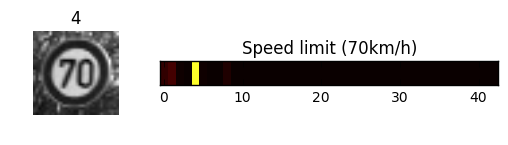

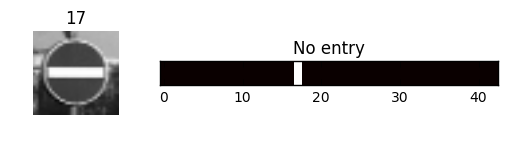

In [14]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

from matplotlib import gridspec

def visualize_prediction(pred, image, label_index, label_name, title, cmap='gray'):
    fig = plt.figure()
    fig.subplots_adjust(hspace=.5)
    
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 4], height_ratios=[1,1])
    subplot = plt.subplot(gs[0])
    subplot.set_title(label_index)
    subplot.axis('off')
    
    if image.shape[2] == 1:
        image = image[:,:,0] * 3
    plt.imshow(image, cmap=cmap)
   
    subplot = plt.subplot(gs[1])
    subplot.set_title(label_name)
    subplot.axes.get_yaxis().set_visible(False)
    probs = np.array([pred, pred, pred])
    plt.imshow(probs, interpolation='nearest', cmap='hot', vmin=0.0, vmax=1.0)

predicted_label_index = np.argmax(softmax_probs, axis=1)
for pred, image, label_index, lable_name, file_name in zip(softmax_probs, web_images, predicted_label_index, sign_names[predicted_label_index], web_file_names):
    visualize_prediction(pred, image, label_index, lable_name, file_name)
    
    

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
For the Beware of ice/snow sign, the correct label is the second choice. For the walking pedestrian, the correct choice is not in the top three.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

TopK: TopKV2(values=array([[  6.68789208e-01,   3.03508729e-01,   2.10275725e-02],
       [  9.99927759e-01,   3.46301422e-05,   2.01940366e-05],
       [  8.04320157e-01,   4.59144376e-02,   3.69644202e-02],
       [  9.51598465e-01,   4.03583683e-02,   6.49636565e-03],
       [  9.30055201e-01,   6.03766479e-02,   3.91276646e-03],
       [  9.99997735e-01,   2.13235558e-06,   1.16471135e-07],
       [  9.99980450e-01,   1.75038913e-05,   1.66914936e-06],
       [  7.85858631e-01,   8.64457637e-02,   6.04999177e-02],
       [  1.00000000e+00,   1.13520589e-26,   1.98387598e-27]], dtype=float32), indices=array([[ 3,  5,  2],
       [14, 17, 38],
       [11, 27, 26],
       [11, 30, 21],
       [ 3,  5,  2],
       [11, 30, 21],
       [ 1,  2,  4],
       [ 4,  1,  0],
       [17, 14, 20]], dtype=int32))


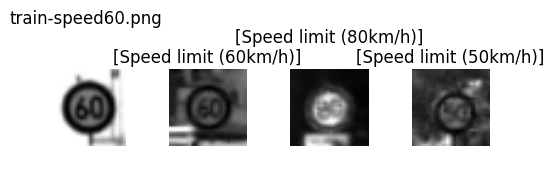

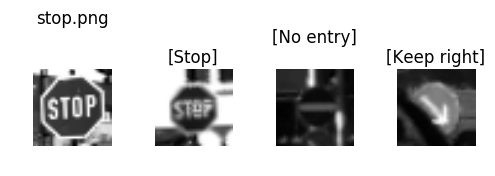

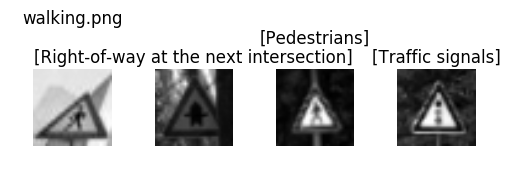

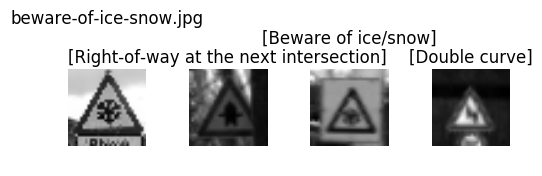

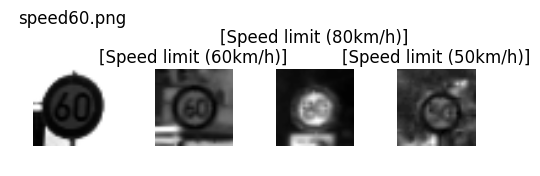

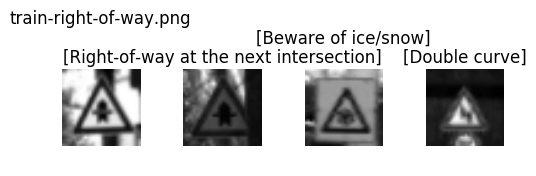

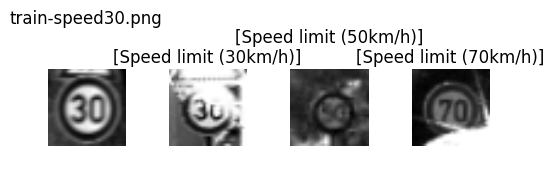

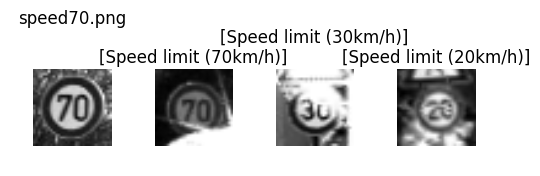

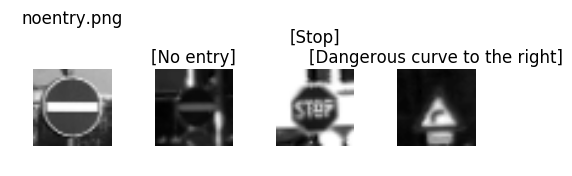

In [15]:
def format_image_for_display(image):
    if image.shape[2] == 1:
        image = image[:,:,0] * 3
    return image

def visualize_topk(top_indices, image, file_name, class_images, class_names, cmap='gray'):
    fig = plt.figure()
    
    gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1, 1, 1])
    
    #  plot evaluated image
    subplot = plt.subplot(gs[0])
    subplot.set_title(file_name, y=1.5)
    subplot.axis('off')
    image = format_image_for_display(image)
    plt.imshow(image, cmap=cmap)
   
    # plot the topk choices predicted
    for p, i in enumerate(top_indices):
        subplot = plt.subplot(gs[p + 1])
        subplot.set_title('[{}]'.format(class_names[i]), y=(1 + 0.25 *(p % 2)))
        subplot.axis('off')
        image = format_image_for_display(class_images[i])
        plt.imshow(image, cmap=cmap)

with tf.Session() as sess:
    topk = sess.run(tf.nn.top_k(tf.constant(softmax_probs), k=3))
    print("TopK: {}".format(topk))

for top_indices, image, file_name in zip(topk[1], web_images, web_file_names):
    visualize_topk(top_indices, image, file_name, sign_samples, sign_names)